In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import calendar

In [2]:
# Read the data
df = pd.read_csv('data.csv')

# Calculate basic average consumption
df['avg_consumption'] = df[['March', 'April', 'May', 'June', 'July', 'August', 'September']].mean(axis=1)

# Display initial info
print("Dataset Overview:")
print(df.info())
print("\nFirst few rows:")
print(df.head())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Name                 14 non-null     object 
 1   Latitude,Longitue    14 non-null     object 
 2   #Person              14 non-null     int64  
 3   Carpet-Area          14 non-null     int64  
 4   Types-of-appliances  14 non-null     object 
 5   September            14 non-null     int64  
 6   August               14 non-null     int64  
 7   July                 14 non-null     int64  
 8   June                 14 non-null     int64  
 9   May                  14 non-null     int64  
 10  April                14 non-null     int64  
 11  March                14 non-null     int64  
 12  House-type           14 non-null     object 
 13  avg_consumption      14 non-null     float64
dtypes: float64(1), int64(9), object(4)
memory usage: 1.7+ KB
None

First few r

In [3]:
def preprocess_data(df):
    """
    Enhanced preprocessing with feature engineering
    """
    # Create seasonal averages
    summer_months = ['June', 'July', 'August', 'September']
    winter_months = ['March', 'April', 'May']
    
    df['summer_avg'] = df[summer_months].mean(axis=1)
    df['winter_avg'] = df[winter_months].mean(axis=1)
    df['seasonal_ratio'] = df['summer_avg'] / df['winter_avg']
    
    # Calculate variability metrics
    df['consumption_std'] = df[['March', 'April', 'May', 'June', 'July', 'August', 'September']].std(axis=1)
    df['consumption_cv'] = df['consumption_std'] / df['avg_consumption']
    
    # Enhanced appliance features
    df['appliance_count'] = df['Types-of-appliances'].str.count(',') + 1
    df['high_power_appliances'] = df['Types-of-appliances'].apply(
        lambda x: sum(1 for app in ['Air conditioner', 'Water Heater', 'Dryer', 'Washing Machine'] 
                     if app in x)
    )
    
    # Per person metrics
    df['area_per_person'] = df['Carpet-Area'] / df['#Person']
    df['consumption_per_person'] = df['avg_consumption'] / df['#Person']
    
    return df

# Apply preprocessing
df_processed = preprocess_data(df)
print("\nProcessed features:")
print(df_processed.columns.tolist())


Processed features:
['Name', 'Latitude,Longitue', '#Person', 'Carpet-Area', 'Types-of-appliances', 'September', 'August', 'July', 'June', 'May', 'April', 'March', 'House-type', 'avg_consumption', 'summer_avg', 'winter_avg', 'seasonal_ratio', 'consumption_std', 'consumption_cv', 'appliance_count', 'high_power_appliances', 'area_per_person', 'consumption_per_person']


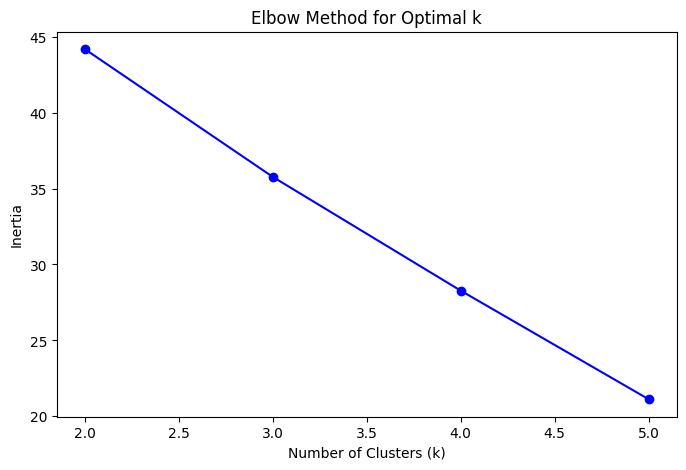


Cluster centers:
[[-0.42706951 -0.34220536  0.2387896  -0.51399998 -0.25315802]
 [ 1.27797289  1.1408408  -0.28179861  0.40704746  1.196747  ]
 [-0.84766774 -0.91286015 -0.39156118  1.24190498 -1.38086193]]


In [4]:
def perform_clustering(df):
    """
    Perform consumption pattern clustering
    """
    # Prepare features for clustering
    features = ['avg_consumption', 'consumption_per_person', 'area_per_person', 
                'seasonal_ratio', 'appliance_count']
    
    X = df[features].copy()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Determine optimal number of clusters
    inertias = []
    for k in range(2, 6):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_scaled)
        inertias.append(kmeans.inertia_)
    
    # Plot elbow curve
    plt.figure(figsize=(8, 5))
    plt.plot(range(2, 6), inertias, 'bo-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')
    plt.show()
    
    # Use 3 clusters for this analysis
    kmeans = KMeans(n_clusters=3, random_state=42)
    df['consumption_cluster'] = kmeans.fit_predict(X_scaled)
    
    return df, kmeans.cluster_centers_

# Perform clustering
df_clustered, cluster_centers = perform_clustering(df_processed)
print("\nCluster centers:")
print(cluster_centers)

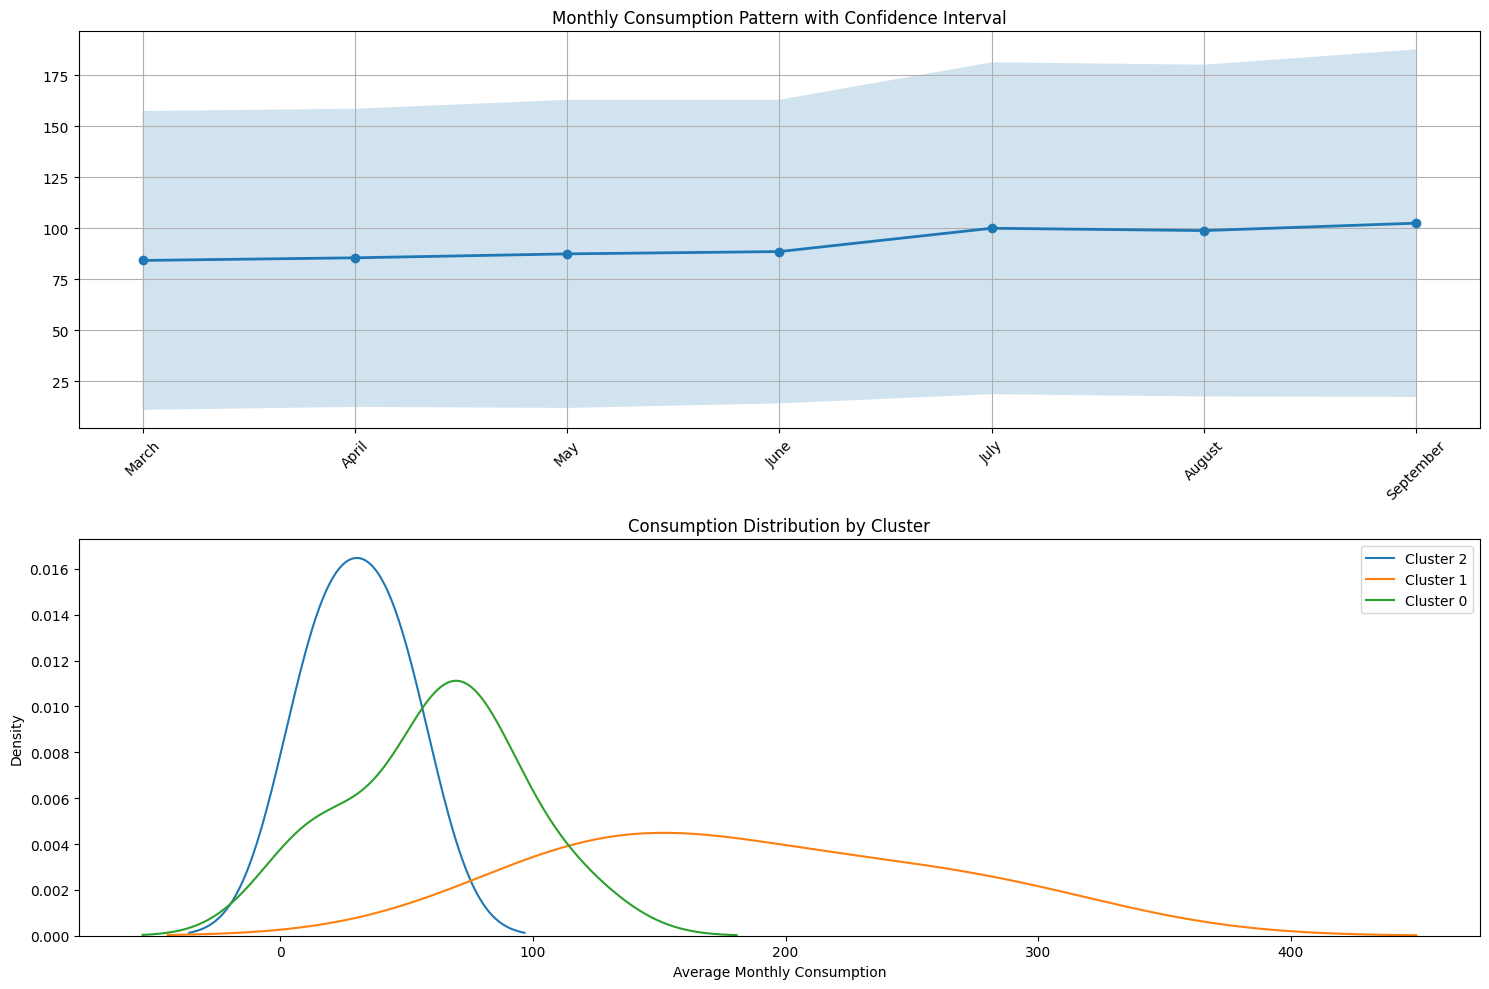

In [5]:
def plot_consumption_patterns(df):
    """
    Create enhanced visualization of consumption patterns
    """
    plt.figure(figsize=(15, 10))
    
    # Create subplots
    plt.subplot(2, 1, 1)
    months = ['March', 'April', 'May', 'June', 'July', 'August', 'September']
    monthly_avg = df[months].mean()
    monthly_std = df[months].std()
    
    # Plot with confidence intervals
    x = range(len(months))
    plt.fill_between(x, 
                    monthly_avg - monthly_std,
                    monthly_avg + monthly_std,
                    alpha=0.2)
    plt.plot(x, monthly_avg, 'o-', linewidth=2)
    plt.xticks(x, months, rotation=45)
    plt.title('Monthly Consumption Pattern with Confidence Interval')
    plt.grid(True)
    
    # Subplot for consumption distribution by cluster
    plt.subplot(2, 1, 2)
    for cluster in df['consumption_cluster'].unique():
        cluster_data = df[df['consumption_cluster'] == cluster]['avg_consumption']
        sns.kdeplot(data=cluster_data, label=f'Cluster {cluster}')
    
    plt.title('Consumption Distribution by Cluster')
    plt.xlabel('Average Monthly Consumption')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Create visualizations
plot_consumption_patterns(df_clustered)

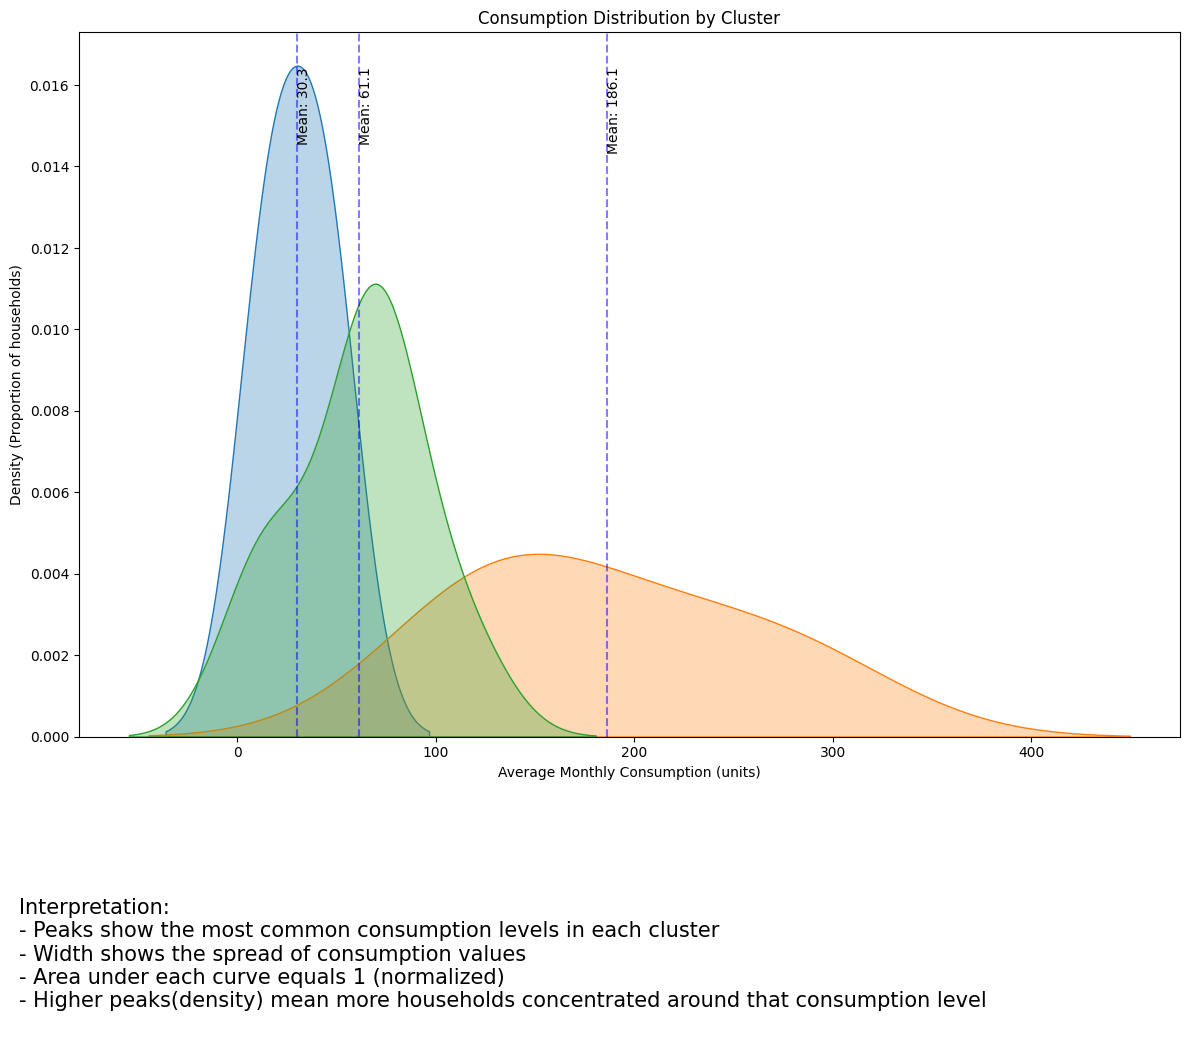

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Enhanced visualization of cluster distributions with annotations
plt.figure(figsize=(12, 8))

# Create the KDE plot with additional information
for cluster in df_clustered['consumption_cluster'].unique():
    # Get data for this cluster
    cluster_data = df_clustered[df_clustered['consumption_cluster'] == cluster]
    
    # Plot the density
    sns.kdeplot(
        data=cluster_data['avg_consumption'],
        label=f'Cluster {cluster} (n={len(cluster_data)})',
        fill=True,
        alpha=0.3
    )
    
    # Add cluster statistics
    avg = cluster_data['avg_consumption'].mean()
    # Define a default color or check if lines exist
    if plt.gca().lines:
        color = plt.gca().lines[-1].get_color()
    else:
        color = 'blue'  # Fallback color
    
    plt.axvline(x=avg, linestyle='--', 
                color=color,
                alpha=0.5)
    plt.text(avg, plt.gca().get_ylim()[1] * 0.95,  # Adjust text position
             f'Mean: {avg:.1f}',
             rotation=90,
             verticalalignment='top')

plt.title('Consumption Distribution by Cluster')
plt.xlabel('Average Monthly Consumption (units)')
plt.ylabel('Density (Proportion of households)')

# Add explanation text
plt.figtext(0.02, -0.1, """
Interpretation:
- Peaks show the most common consumption levels in each cluster
- Width shows the spread of consumption values
- Area under each curve equals 1 (normalized)
- Higher peaks(density) mean more households concentrated around that consumption level
""", ha='left', va='top', fontsize=15)

plt.tight_layout()
plt.show()


In [12]:
# Print cluster summaries
print("\nCluster Summaries:")
for cluster in df_clustered['consumption_cluster'].unique():
    cluster_data = df_clustered[df_clustered['consumption_cluster'] == cluster]
    print(f"\nCluster {cluster}:")
    print(f"Number of households: {len(cluster_data)}")
    print(f"Average consumption: {cluster_data['avg_consumption'].mean():.1f} units")
    print(f"Min consumption: {cluster_data['avg_consumption'].min():.1f} units")
    print(f"Max consumption: {cluster_data['avg_consumption'].max():.1f} units")
    print("\nTypical characteristics:")
    print(f"Avg appliances: {cluster_data['appliance_count'].mean():.1f}")
    print(f"Avg household size: {cluster_data['#Person'].mean():.1f} persons")
    print(f"Avg carpet area: {cluster_data['Carpet-Area'].mean():.1f} sq ft")


Cluster Summaries:

Cluster 2:
Number of households: 2
Average consumption: 30.3 units
Min consumption: 16.1 units
Max consumption: 44.4 units

Typical characteristics:
Avg appliances: 2.0
Avg household size: 3.0 persons
Avg carpet area: 800.0 sq ft

Cluster 1:
Number of households: 4
Average consumption: 186.1 units
Min consumption: 123.1 units
Max consumption: 282.0 units

Typical characteristics:
Avg appliances: 6.0
Avg household size: 4.8 persons
Avg carpet area: 1250.0 sq ft

Cluster 0:
Number of households: 8
Average consumption: 61.1 units
Min consumption: 11.7 units
Max consumption: 114.4 units

Typical characteristics:
Avg appliances: 3.8
Avg household size: 3.0 persons
Avg carpet area: 912.5 sq ft


In [6]:
def analyze_efficiency(df):
    """
    Calculate and analyze efficiency metrics
    """
    results = {
        'efficiency_metrics': {
            'avg_consumption_per_sqft': df['avg_consumption'].mean() / df['Carpet-Area'].mean(),
            'avg_consumption_per_person': df['avg_consumption'].mean() / df['#Person'].mean(),
            'avg_consumption_per_appliance': df['avg_consumption'].mean() / df['appliance_count'].mean()
        },
        'correlations': {
            'area_vs_consumption': stats.pearsonr(df['Carpet-Area'], df['avg_consumption'])[0],
            'persons_vs_consumption': stats.pearsonr(df['#Person'], df['avg_consumption'])[0],
            'appliances_vs_consumption': stats.pearsonr(df['appliance_count'], df['avg_consumption'])[0]
        },
        'efficiency_rankings': df.nsmallest(3, 'consumption_per_person')[
            ['Name', 'avg_consumption', 'consumption_per_person', 'appliance_count']
        ]
    }
    return results

# Get efficiency metrics
efficiency_results = analyze_efficiency(df_clustered)
print("\nEfficiency Analysis Results:")
print("\nEfficiency Metrics:")
for metric, value in efficiency_results['efficiency_metrics'].items():
    print(f"{metric}: {value:.3f}")
print("\nCorrelations:")
for correlation, value in efficiency_results['correlations'].items():
    print(f"{correlation}: {value:.3f}")
print("\nMost Efficient Households:")
print(efficiency_results['efficiency_rankings'])


Efficiency Analysis Results:

Efficiency Metrics:
avg_consumption_per_sqft: 0.093
avg_consumption_per_person: 26.411
avg_consumption_per_appliance: 22.313

Correlations:
area_vs_consumption: 0.606
persons_vs_consumption: 0.642
appliances_vs_consumption: 0.693

Most Efficient Households:
                      Name  avg_consumption  consumption_per_person  \
8           Shyamal Biswas        16.142857                5.380952   
3   Khagendranath Majumder        17.142857                8.571429   
12          Mangala Biswas        11.714286               11.714286   

    appliance_count  
8                 2  
3                 3  
12                4  


In [7]:
def predict_consumption(df):
    """
    Train an enhanced prediction model using RandomForest
    """
    features = ['Carpet-Area', '#Person', 'appliance_count', 'high_power_appliances',
                'area_per_person', 'seasonal_ratio']
    
    X = df[features]
    y = df['avg_consumption']
    
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    
    # Fit final model and get feature importance
    model.fit(X, y)
    feature_importance = pd.DataFrame({
        'feature': features,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    return {
        'cv_scores': scores,
        'mean_r2': scores.mean(),
        'feature_importance': feature_importance
    }

# Train and evaluate model
prediction_results = predict_consumption(df_clustered)

print("\nPrediction Model Results:")
print(f"Cross-validation R² scores: {prediction_results['cv_scores']}")
print(f"Mean R² score: {prediction_results['mean_r2']:.3f}")
print("\nFeature Importance:")
print(prediction_results['feature_importance'])


Prediction Model Results:
Cross-validation R² scores: [-0.27851127 -0.93243758 -3.29343883  0.19726191  0.84359063]
Mean R² score: -0.693

Feature Importance:
                 feature  importance
2        appliance_count    0.299151
0            Carpet-Area    0.234813
1                #Person    0.228288
5         seasonal_ratio    0.105485
4        area_per_person    0.084713
3  high_power_appliances    0.047549


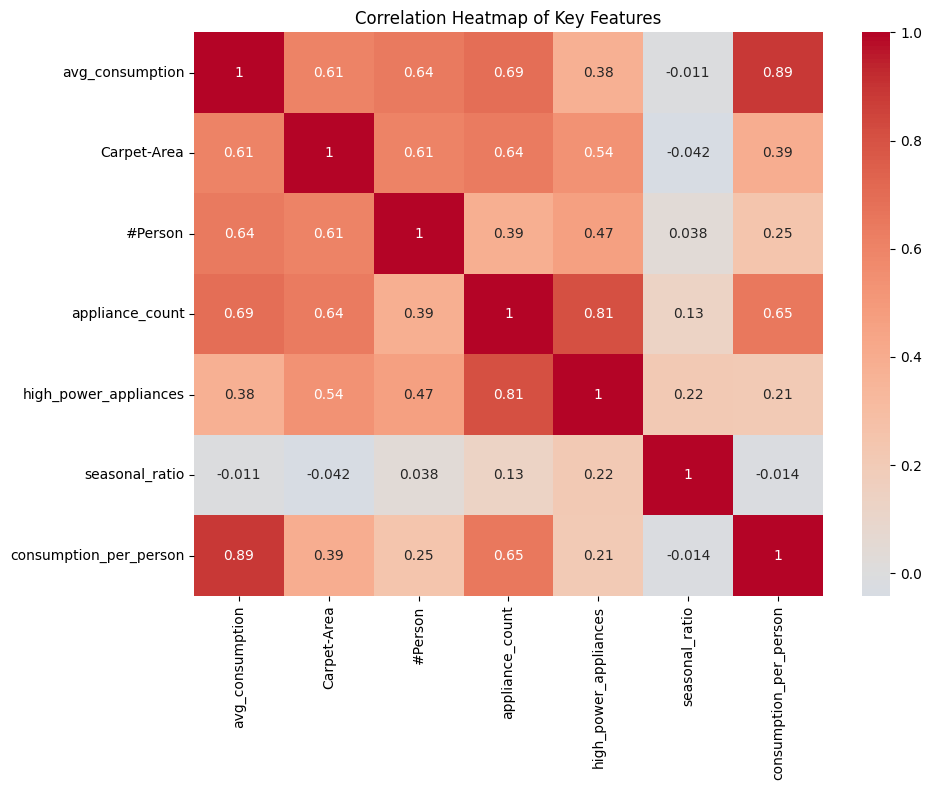

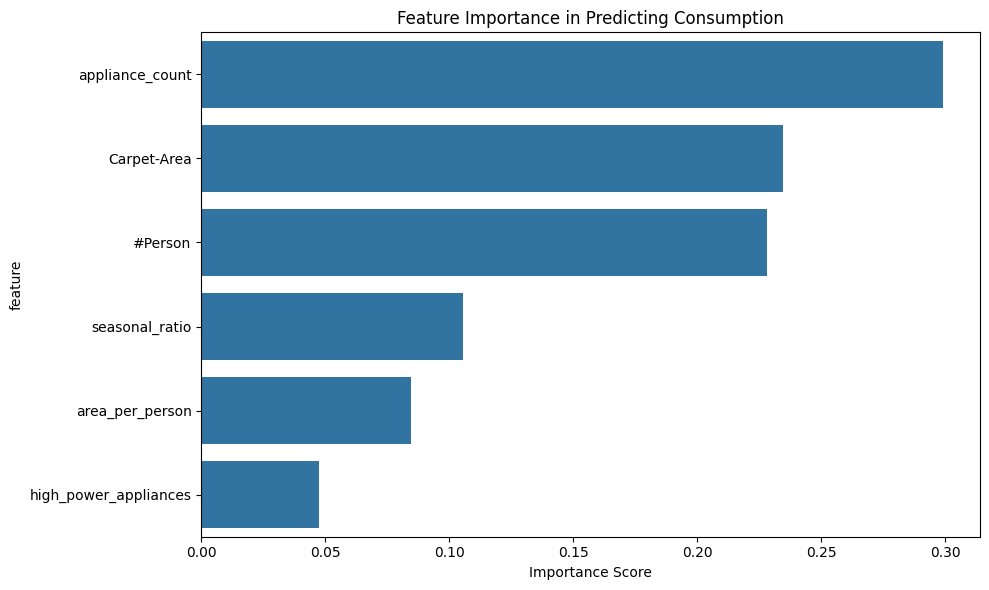

In [8]:
# Create correlation heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = df_clustered[[
    'avg_consumption', 'Carpet-Area', '#Person', 
    'appliance_count', 'high_power_appliances', 
    'seasonal_ratio', 'consumption_per_person'
]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Key Features')
plt.tight_layout()
plt.show()

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(
    data=prediction_results['feature_importance'],
    x='importance',
    y='feature'
)
plt.title('Feature Importance in Predicting Consumption')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()